<a href="https://colab.research.google.com/github/FernandaSzAdr/KNN_cromossome/blob/master/TesteRede2_Colorida_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).




---



In [4]:
import os
import cv2
import csv
!pip install imutils
import imutils
from skimage import transform
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import itertools
import matplotlib.pyplot as plt

Using TensorFlow backend.




---



## Funções

In [0]:
train_path = 'drive/My Drive/Base_CNN/Colorido2/Train'
test_path = 'drive/My Drive/Base_CNN/Colorido2/Test'
validation_path = 'drive/My Drive/Base_CNN/Colorido2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Base_CNN/Colorido2/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Se é um cromossomo:
            if predicao[0][0] > predicao[0][1]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict




---



## Implementação



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [11]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 4369 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [13]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



### 1 tentativa Precision: 19.64%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_1'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [18]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 80s - loss: 0.6936 - acc: 0.5312 - val_loss: 0.7158 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 0.71584, saving model to drive/My Drive/Resultado/weights_architecture_1.hdf5
Epoch 2/50
 - 75s - loss: 0.7160 - acc: 0.4875 - val_loss: 0.7060 - val_acc: 0.3750

Epoch 00002: val_loss improved from 0.71584 to 0.70599, saving model to drive/My Drive/Resultado/weights_architecture_1.hdf5
Epoch 3/50
 - 73s - loss: 0.7032 - acc: 0.4688 - val_loss: 0.6916 - val_acc: 0.5312

Epoch 00003: val_loss improved from 0.70599 to 0.69160, saving model to drive/My Drive/Resultado/weights_architecture_1.hdf5
Epoch 4/50
 - 74s - loss: 0.7022 - acc: 0.4937 - val_loss: 0.7010 - val_acc: 0.4062

Epoch 00004: val_loss did not improve from 0.69160
Epoch 5/50
 - 72s - loss: 0.6948 - acc: 0.4937 - val_loss: 0.7477 - val_acc: 0.3750

Epoch 00005: val_loss did not improve from 0.69160
Epoch 6/50
 - 75s - loss: 0.7212 - acc: 0.4750 - val_loss: 0.7816 - val_acc: 0.3750

Epoch 00006: val_

In [0]:
model.load_weights('drive/My Drive/Resultado/weights_architecture_1.hdf5')

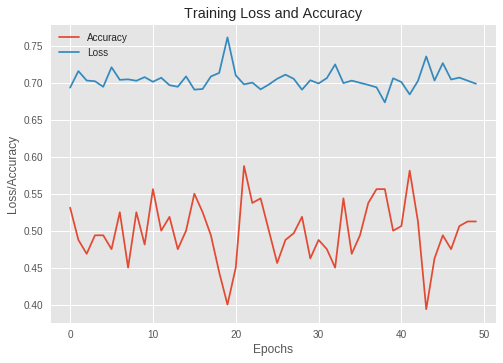

In [20]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [21]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 19.64%




---



### 2 tentativa  Precision: 3.63%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_2'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [27]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6911 - acc: 0.5438 - val_loss: 0.6930 - val_acc: 0.4839

Epoch 00001: val_loss improved from inf to 0.69301, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6907 - acc: 0.6125 - val_loss: 0.6914 - val_acc: 0.5312

Epoch 00002: val_loss improved from 0.69301 to 0.69137, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6867 - acc: 0.5800 - val_loss: 0.6885 - val_acc: 0.8438

Epoch 00003: val_loss improved from 0.69137 to 0.68852, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6832 - acc: 0.7438 - val_loss: 0.6860 - val_acc: 0.6250

Epoch 00004: val_loss improved from 0.68852 to 0.68598, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 5/50
 - 1s - loss: 0.6774 - acc: 0.7875 - val_loss: 0.6859 - val_acc: 0.8438

Epoch 00005: val_loss improved from 0.68598 to 0.68589, saving model to drive/My Dri

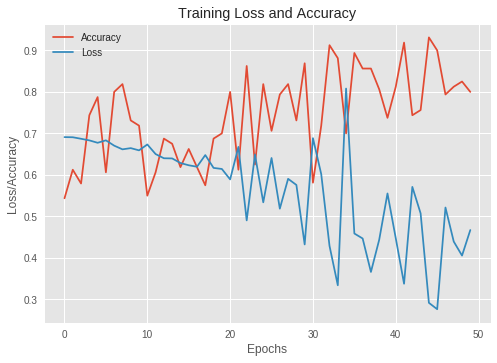

In [28]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [29]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [30]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 3.63%


### 3 tentativa Precision: 7.92%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_3'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [35]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.0499 - acc: 0.6312 - val_loss: 0.7675 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 0.76754, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 0.7301 - acc: 0.7812 - val_loss: 0.6437 - val_acc: 0.8226

Epoch 00002: val_loss improved from 0.76754 to 0.64373, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 3/50
 - 0s - loss: 0.5460 - acc: 0.7875 - val_loss: 0.6689 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.64373
Epoch 4/50
 - 0s - loss: 0.3277 - acc: 0.8812 - val_loss: 0.8635 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0.64373
Epoch 5/50
 - 0s - loss: 0.3967 - acc: 0.8719 - val_loss: 1.4883 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 0.64373
Epoch 6/50
 - 1s - loss: 0.3751 - acc: 0.8527 - val_loss: 0.4857 - val_acc: 0.7656

Epoch 00006: val_loss improved from 0.64373 to 0.48565, saving model to drive/My Drive/Resultado/

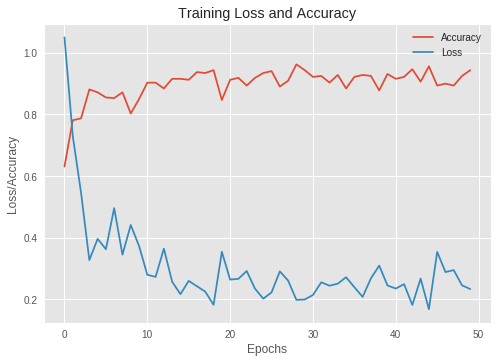

In [36]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [37]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [38]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 7.92%


### 4 tentativa Precision: 16.41%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_4'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [43]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.5663 - acc: 0.7469 - val_loss: 0.6861 - val_acc: 0.7031

Epoch 00001: val_loss improved from inf to 0.68608, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 2/50
 - 0s - loss: 0.3162 - acc: 0.8844 - val_loss: 0.4349 - val_acc: 0.8125

Epoch 00002: val_loss improved from 0.68608 to 0.43491, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 3/50
 - 0s - loss: 0.2917 - acc: 0.8875 - val_loss: 1.0054 - val_acc: 0.6774

Epoch 00003: val_loss did not improve from 0.43491
Epoch 4/50
 - 0s - loss: 0.3465 - acc: 0.8812 - val_loss: 0.5652 - val_acc: 0.7812

Epoch 00004: val_loss did not improve from 0.43491
Epoch 5/50
 - 0s - loss: 0.1625 - acc: 0.9625 - val_loss: 1.2103 - val_acc: 0.6875

Epoch 00005: val_loss did not improve from 0.43491
Epoch 6/50
 - 0s - loss: 0.1870 - acc: 0.9656 - val_loss: 0.7741 - val_acc: 0.8125

Epoch 00006: val_loss did not improve from 0.43491
Epoch 7/50
 - 0s - loss: 0.2493 - acc: 0.9031 

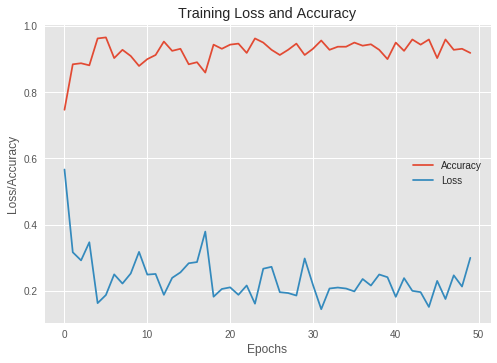

In [44]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [45]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [46]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 16.41%


### 5 tentativa Precision: 13.57%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_5'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [51]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 1.2862 - acc: 0.5469 - val_loss: 0.6809 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 0.68092, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 2/50
 - 0s - loss: 0.8029 - acc: 0.6344 - val_loss: 0.7161 - val_acc: 0.6406

Epoch 00002: val_loss did not improve from 0.68092
Epoch 3/50
 - 0s - loss: 0.6709 - acc: 0.7469 - val_loss: 0.8114 - val_acc: 0.5625

Epoch 00003: val_loss did not improve from 0.68092
Epoch 4/50
 - 0s - loss: 0.5083 - acc: 0.7906 - val_loss: 0.6559 - val_acc: 0.6613

Epoch 00004: val_loss improved from 0.68092 to 0.65587, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 5/50
 - 0s - loss: 0.6568 - acc: 0.7500 - val_loss: 0.7105 - val_acc: 0.7500

Epoch 00005: val_loss did not improve from 0.65587
Epoch 6/50
 - 0s - loss: 0.4236 - acc: 0.8438 - val_loss: 0.7516 - val_acc: 0.6406

Epoch 00006: val_loss did not improve from 0.65587
Epoch 7/50
 - 0s - loss: 0.5186 - acc: 0.7875 

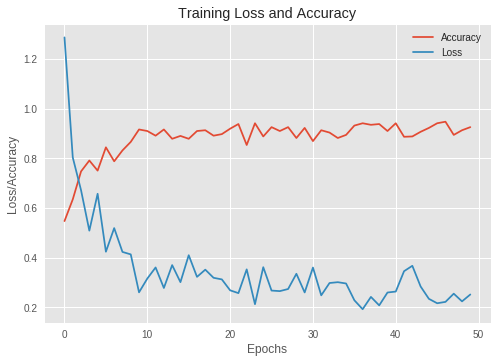

In [52]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [53]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [54]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 13.57%


### 6 tentativa Precision: 3.78%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_6'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [59]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.6126 - acc: 0.7250 - val_loss: 1.0934 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 1.09342, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.4338 - acc: 0.8312 - val_loss: 7.1653 - val_acc: 0.4688

Epoch 00002: val_loss did not improve from 1.09342
Epoch 3/50
 - 0s - loss: 0.3310 - acc: 0.8969 - val_loss: 2.8625 - val_acc: 0.4062

Epoch 00003: val_loss did not improve from 1.09342
Epoch 4/50
 - 0s - loss: 0.3737 - acc: 0.8844 - val_loss: 0.7879 - val_acc: 0.7188

Epoch 00004: val_loss improved from 1.09342 to 0.78787, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 5/50
 - 0s - loss: 0.2709 - acc: 0.9188 - val_loss: 0.6055 - val_acc: 0.7258

Epoch 00005: val_loss improved from 0.78787 to 0.60550, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 6/50
 - 0s - loss: 0.1983 - acc: 0.9406 - val_loss: 0.7085 - val_acc: 0.6719

Epoch 00006: val_loss d

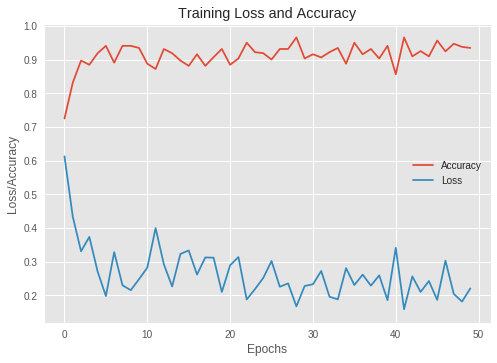

In [60]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [61]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [62]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 3.78%


### 7 tentativa Precision: 1.19%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_7'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [67]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.6239 - acc: 0.7031 - val_loss: 0.7158 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 0.71578, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 2/50
 - 0s - loss: 0.3491 - acc: 0.8750 - val_loss: 0.4855 - val_acc: 0.7812

Epoch 00002: val_loss improved from 0.71578 to 0.48552, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 3/50
 - 0s - loss: 0.4890 - acc: 0.7906 - val_loss: 0.7749 - val_acc: 0.6875

Epoch 00003: val_loss did not improve from 0.48552
Epoch 4/50
 - 0s - loss: 0.3713 - acc: 0.8781 - val_loss: 1.7963 - val_acc: 0.5469

Epoch 00004: val_loss did not improve from 0.48552
Epoch 5/50
 - 0s - loss: 0.3695 - acc: 0.8812 - val_loss: 1.5663 - val_acc: 0.4375

Epoch 00005: val_loss did not improve from 0.48552
Epoch 6/50
 - 0s - loss: 0.2370 - acc: 0.9219 - val_loss: 0.5581 - val_acc: 0.7581

Epoch 00006: val_loss did not improve from 0.48552
Epoch 7/50
 - 0s - loss: 0.3289 - acc: 0.8844 

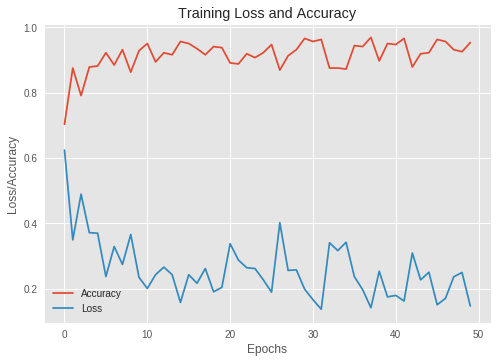

In [68]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [69]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [70]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 1.19%


### 8 tentativa Precision: 0.00%

Modelo adaptado do **Lucas Albertins**

*   Função **Adadelta** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_8'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [75]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.0968 - acc: 0.6363 - val_loss: 0.6315 - val_acc: 0.7344

Epoch 00001: val_loss improved from inf to 0.63154, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 0.8788 - acc: 0.7062 - val_loss: 1.1126 - val_acc: 0.6562

Epoch 00002: val_loss did not improve from 0.63154
Epoch 3/50
 - 1s - loss: 0.5118 - acc: 0.8250 - val_loss: 1.0024 - val_acc: 0.6094

Epoch 00003: val_loss did not improve from 0.63154
Epoch 4/50
 - 0s - loss: 0.5449 - acc: 0.8344 - val_loss: 0.8068 - val_acc: 0.6406

Epoch 00004: val_loss did not improve from 0.63154
Epoch 5/50
 - 1s - loss: 0.5823 - acc: 0.8031 - val_loss: 1.4141 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 0.63154
Epoch 6/50
 - 0s - loss: 0.5744 - acc: 0.8063 - val_loss: 0.7118 - val_acc: 0.6250

Epoch 00006: val_loss did not improve from 0.63154
Epoch 7/50
 - 0s - loss: 0.4444 - acc: 0.8625 - val_loss: 0.3146 - val_acc: 0.9355

Epoch 00007: val_loss improved from 

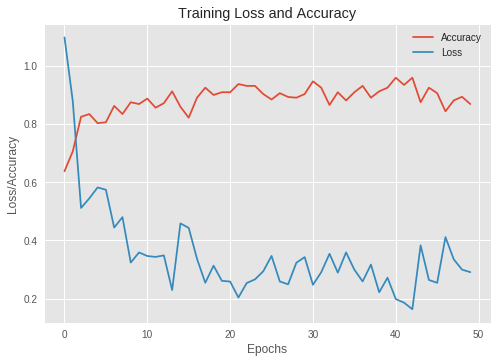

In [76]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [77]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [78]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 0.00%


### 9 tentativa Precision: 3.37%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_9'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [83]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 1.3540 - acc: 0.5750 - val_loss: 0.6640 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 0.66397, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 2/50
 - 0s - loss: 1.1479 - acc: 0.6312 - val_loss: 0.6724 - val_acc: 0.7188

Epoch 00002: val_loss did not improve from 0.66397
Epoch 3/50
 - 0s - loss: 0.6243 - acc: 0.7594 - val_loss: 0.5420 - val_acc: 0.7500

Epoch 00003: val_loss improved from 0.66397 to 0.54202, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 4/50
 - 0s - loss: 0.5261 - acc: 0.8125 - val_loss: 0.6570 - val_acc: 0.7500

Epoch 00004: val_loss did not improve from 0.54202
Epoch 5/50
 - 0s - loss: 0.3513 - acc: 0.9062 - val_loss: 0.7637 - val_acc: 0.5156

Epoch 00005: val_loss did not improve from 0.54202
Epoch 6/50
 - 0s - loss: 0.4515 - acc: 0.8481 - val_loss: 0.6037 - val_acc: 0.7188

Epoch 00006: val_loss did not improve from 0.54202
Epoch 7/50
 - 0s - loss: 0.2704 - acc: 0.9125 

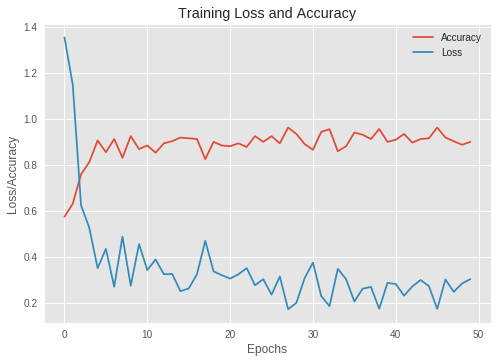

In [84]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [85]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [86]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 3.37%


### 10 tentativa Precision: 10.95%

Modelo adaptado do **Lucas Albertins**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_10'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [91]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 0.9090 - acc: 0.6469 - val_loss: 0.4879 - val_acc: 0.7969

Epoch 00001: val_loss improved from inf to 0.48790, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 0.4742 - acc: 0.8250 - val_loss: 0.5206 - val_acc: 0.7656

Epoch 00002: val_loss did not improve from 0.48790
Epoch 3/50
 - 1s - loss: 0.2838 - acc: 0.9219 - val_loss: 0.4175 - val_acc: 0.8125

Epoch 00003: val_loss improved from 0.48790 to 0.41754, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 4/50
 - 1s - loss: 0.5616 - acc: 0.8438 - val_loss: 0.4731 - val_acc: 0.8438

Epoch 00004: val_loss did not improve from 0.41754
Epoch 5/50
 - 1s - loss: 0.5000 - acc: 0.8531 - val_loss: 0.7097 - val_acc: 0.7500

Epoch 00005: val_loss did not improve from 0.41754
Epoch 6/50
 - 1s - loss: 0.5071 - acc: 0.8250 - val_loss: 0.5962 - val_acc: 0.7969

Epoch 00006: val_loss did not improve from 0.41754
Epoch 7/50
 - 1s - loss: 0.3922 - acc: 0.862

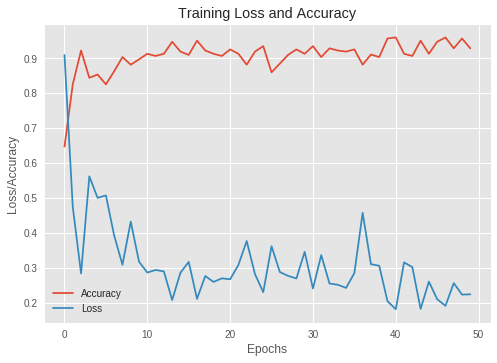

In [92]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [93]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [94]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 10.95%


### 11 tentativa Precision: 0.00%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_11'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [99]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.3846 - acc: 0.5531 - val_loss: 0.9178 - val_acc: 0.3594

Epoch 00001: val_loss improved from inf to 0.91780, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 0.8960 - acc: 0.6781 - val_loss: 0.7459 - val_acc: 0.7344

Epoch 00002: val_loss improved from 0.91780 to 0.74590, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 0.8150 - acc: 0.7406 - val_loss: 0.6554 - val_acc: 0.7656

Epoch 00003: val_loss improved from 0.74590 to 0.65542, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 4/50
 - 1s - loss: 0.5528 - acc: 0.8406 - val_loss: 0.6185 - val_acc: 0.7656

Epoch 00004: val_loss improved from 0.65542 to 0.61846, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 5/50
 - 1s - loss: 0.4620 - acc: 0.8406 - val_loss: 0.5250 - val_acc: 0.7812

Epoch 00005: val_loss improved from 0.61846 to 0.52498, saving model to drive/My

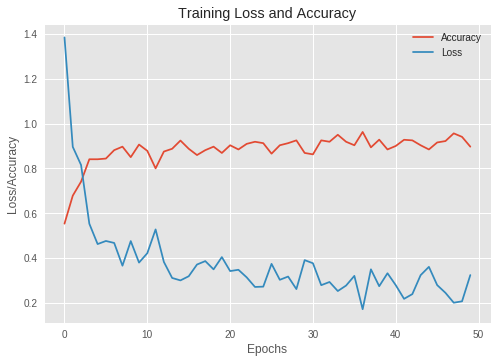

In [100]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [101]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [102]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 0.00%


### 12 tentativa Precision: 1.24%

Modelo adaptado do **Lucas Albertins**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_12'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [107]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.1525 - acc: 0.5625 - val_loss: 0.6676 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 0.66763, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 0.7208 - acc: 0.7062 - val_loss: 0.5182 - val_acc: 0.7812

Epoch 00002: val_loss improved from 0.66763 to 0.51817, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 0.5096 - acc: 0.7562 - val_loss: 0.6822 - val_acc: 0.7031

Epoch 00003: val_loss did not improve from 0.51817
Epoch 4/50
 - 1s - loss: 0.4759 - acc: 0.8281 - val_loss: 0.4975 - val_acc: 0.7969

Epoch 00004: val_loss improved from 0.51817 to 0.49751, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 5/50
 - 1s - loss: 0.4077 - acc: 0.8469 - val_loss: 0.5922 - val_acc: 0.7031

Epoch 00005: val_loss did not improve from 0.49751
Epoch 6/50
 - 1s - loss: 0.3078 - acc: 0.8688 - val_loss: 0.4497 - val_acc: 0.8125

Epoch 00006: val_los

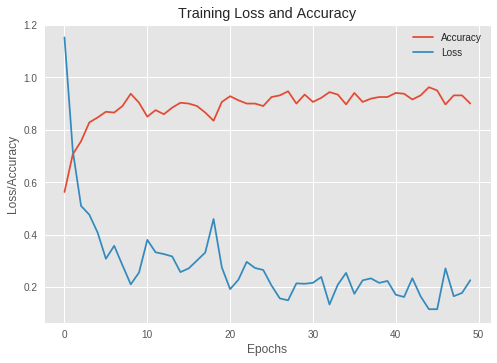

In [108]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [109]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [110]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 1.24%


### 13 tentativa Precision: 4.30%

Modelo adaptado do **Lucas Albertins**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_13'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [115]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 0.5903 - acc: 0.7625 - val_loss: 1.0837 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 1.08373, saving model to drive/My Drive/Resultado/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.4334 - acc: 0.8594 - val_loss: 0.6367 - val_acc: 0.8125

Epoch 00002: val_loss improved from 1.08373 to 0.63672, saving model to drive/My Drive/Resultado/weights_architecture_13.hdf5
Epoch 3/50
 - 0s - loss: 0.5863 - acc: 0.8594 - val_loss: 0.4870 - val_acc: 0.7656

Epoch 00003: val_loss improved from 0.63672 to 0.48700, saving model to drive/My Drive/Resultado/weights_architecture_13.hdf5
Epoch 4/50
 - 0s - loss: 0.4010 - acc: 0.8563 - val_loss: 0.4656 - val_acc: 0.7812

Epoch 00004: val_loss improved from 0.48700 to 0.46557, saving model to drive/My Drive/Resultado/weights_architecture_13.hdf5
Epoch 5/50
 - 0s - loss: 0.4443 - acc: 0.8438 - val_loss: 0.2855 - val_acc: 0.8906

Epoch 00005: val_loss improved from 0.46557 to 0.28555, saving model to drive/My

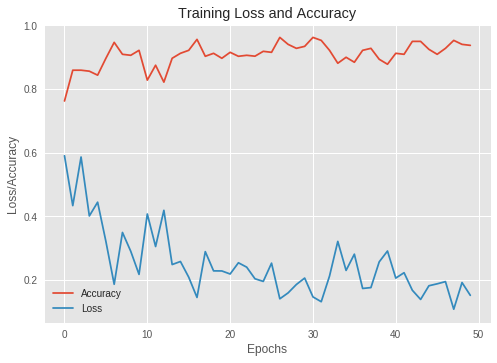

In [116]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [117]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [118]:
results[arquiteture] = precision_score(y_true, y_predict, average='binary')
print('Test Precision: {:.2f}%'
      .format(100 * results[arquiteture]))

Test Precision: 4.30%
